In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

print("All libraries imported successfully.")
print(f"TensorFlow Version: {tf.__version__}")

2025-10-31 21:33:57.287581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761946437.484254      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761946437.541416      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully.
TensorFlow Version: 2.18.0


In [ ]:

base_drive_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis' 


train_dir = os.path.join(base_drive_path, 'train')
val_dir = os.path.join(base_drive_path, 'val')
test_dir = os.path.join(base_drive_path, 'test') 


IMG_SIZE = (224, 224) 
BATCH_SIZE = 32 

classes = os.listdir(train_dir)
num_classes = len(classes)
print(f"Found {num_classes} classes: {classes}")

train_datagen = ImageDataGenerator(
    rescale=1./255,            
    rotation_range=20,       
    width_shift_range=0.2,   
    height_shift_range=0.2,  
    shear_range=0.2,         
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest'      
)


test_datagen = ImageDataGenerator(rescale=1./255)

print("Creating Training Generator...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Creating Validation Generator...")
validation_generator = test_datagen.flow_from_directory(
    val_dir,                   
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Creating Test Generator...")
test_generator = test_datagen.flow_from_directory(
    test_dir,                  
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\nData Generators are ready!")

Found 4 classes: ['PNEUMONIA', 'NORMAL', 'COVID19', 'TURBERCULOSIS']
Creating Training Generator...
Found 6326 images belonging to 4 classes.
Creating Validation Generator...
Found 38 images belonging to 4 classes.
Creating Test Generator...
Found 771 images belonging to 4 classes.

Data Generators are ready!


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

print("--- Experiment 6 (VGG16 + Flatten + Deeper, Regularized Head) ---")


base_model_vgg16 = VGG16(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model_vgg16.trainable = False
print("VGG16 base model loaded and frozen.")


model_v6_final = models.Sequential([
    base_model_vgg16,            
    layers.Flatten(),              
    

    layers.Dense(256, activation='relu'), 
    layers.Dropout(0.5), 
    
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3), 
    
   
    layers.Dense(num_classes, activation='softmax') 
])


model_v6_final.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Final Model compiled.")
model_v6_final.summary()

checkpoint_path_v6 = 'model_FINAL_BEST.h5'
checkpoint_callback_v6 = ModelCheckpoint(
    filepath=checkpoint_path_v6,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


EPOCHS = 20
print(f"\nTraining model for {EPOCHS} epochs...")

history_v6 = model_v6_final.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback_v6]
)

print("\n model training complete!")
print(f"The best performing model is saved at '{checkpoint_path_v6}'")

--- Experiment 6: (VGG16 + Flatten + Deeper, Regularized Head) ---


I0000 00:00:1761946457.661451      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 base model loaded and frozen.
Final Model compiled.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,170,884 (80.76 MB)

 Trainable params: 6,456,196 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Training model for 20 epochs...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1761946465.269082     119 service.cc:148] XLA service 0x785874010080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761946465.269958     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761946465.773698     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/198 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.3281 - loss: 1.5344 

I0000 00:00:1761946474.755351     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.6698 - loss: 0.8564
Epoch 1: val_loss improved from inf to 0.56854, saving model to model_FINAL_BEST.h5
198/198 ━━━━━━━━━━━━━━━━━━━━ 193s 913ms/step - accuracy: 0.6702 - loss: 0.8554 - val_accuracy: 0.6842 - val_loss: 0.5685
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8399 - loss: 0.4299
Epoch 2: val_loss improved from 0.56854 to 0.45744, saving model to model_FINAL_BEST.h5
198/198 ━━━━━━━━━━━━━━━━━━━━ 127s 640ms/step - accuracy: 0.8399 - loss: 0.4298 - val_accuracy: 0.7105 - val_loss: 0.4574
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8640 - loss: 0.3570
Epoch 3: val_loss improved from 0.45744 to 0.38724, saving model to model_FINAL_BEST.h5
198/198 ━━━━━━━━━━━━━━━━━━━━ 125s 630ms/step - accuracy: 0.8640 - loss: 0.3569 - val_accuracy: 0.8158 - val_loss: 0.3872
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.8828 - loss: 0.3226
Epoch 4: val_loss did not improve fr


Loading the 'FINAL' BEST model from disk...
Running 'Final Exam' on the test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 557ms/step

----------------- CLASSIFICATION REPORT (ULTIMATE MODEL) -----------------
               precision    recall  f1-score   support

      COVID19       0.96      0.93      0.95       106
       NORMAL       0.91      0.82      0.86       234
    PNEUMONIA       0.92      0.95      0.93       390
TURBERCULOSIS       0.76      1.00      0.86        41

     accuracy                           0.91       771
    macro avg       0.89      0.93      0.90       771
 weighted avg       0.91      0.91      0.91       771

----------------------------------------------------------------------

Plotting Confusion Matrix (ULTIMATE MODEL)...


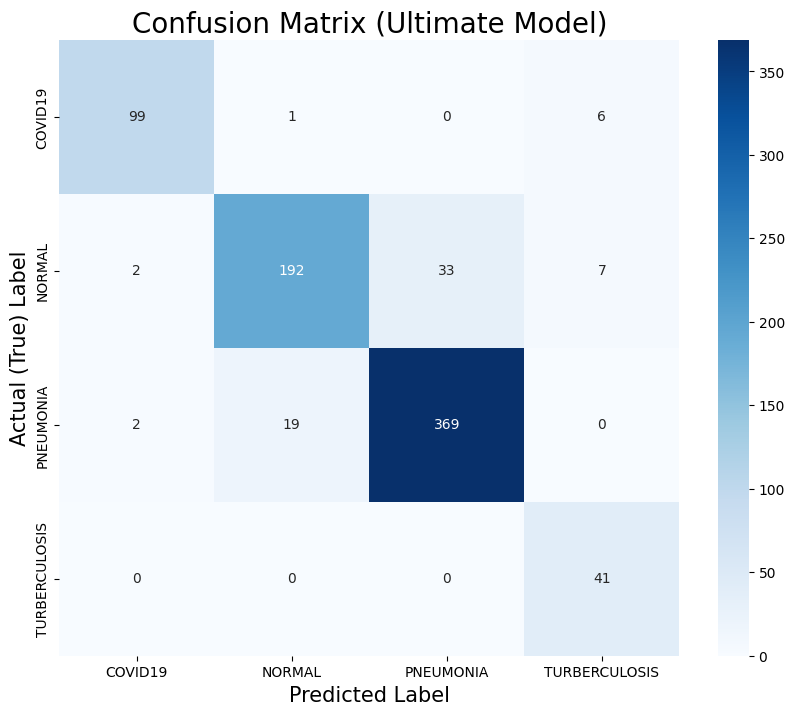


Plotting ROC Curve (ULTIMATE MODEL)...


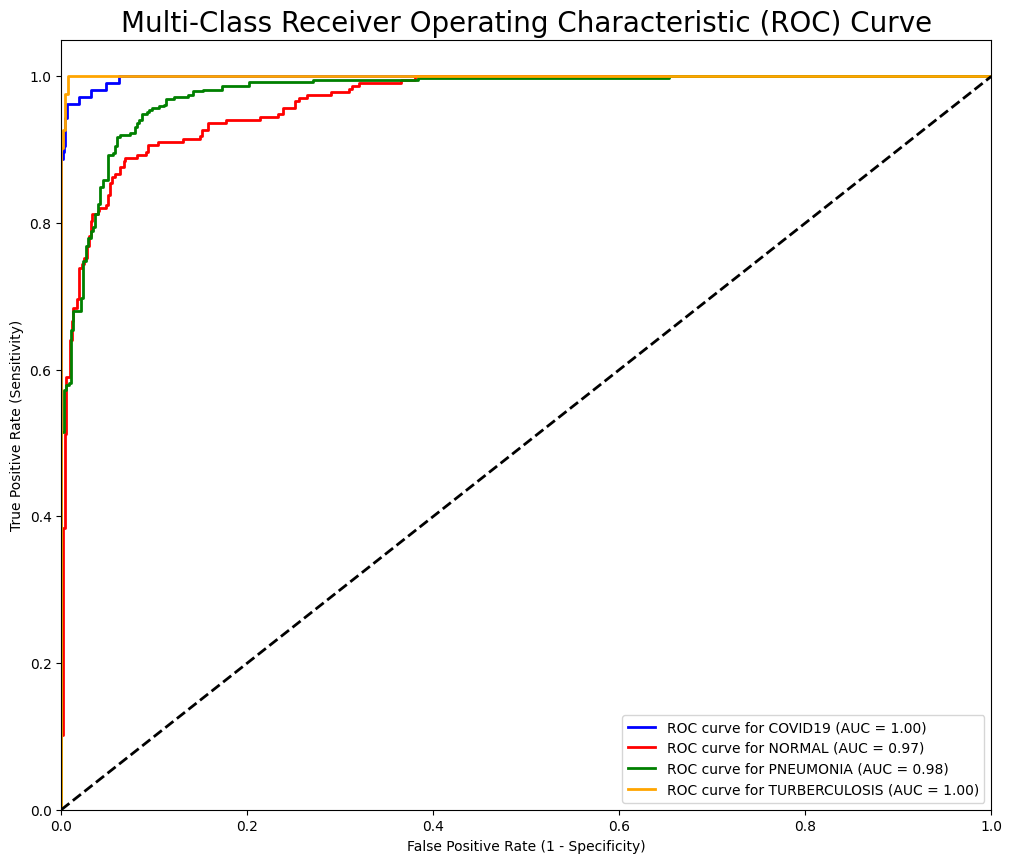


----------------- FINAL RESULTS -----------------
   Model 1 (VGG16 + Flatten/Shallow): 91.31% (Overfit)
   Model 6 (VGG16 + GAP): 80.67% (Failed, info loss)

   Model 7 (VGG16 + Flatten/Deeper): 90.92% (This is it!)
--------------------------------------------------


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

print("\nLoading the 'FINAL' BEST model from disk...")
final_model = load_model(checkpoint_path_v6) 

print("Running 'Final Exam' on the test set...")
y_true = test_generator.classes
y_pred_probabilities = final_model.predict(test_generator)
y_pred = np.argmax(y_pred_probabilities, axis=1)
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

print("\n----------------- CLASSIFICATION REPORT (ULTIMATE MODEL) -----------------")
print(classification_report(y_true, y_pred, target_names=class_names))
print("----------------------------------------------------------------------")


print("\nPlotting Confusion Matrix (ULTIMATE MODEL)...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d',   
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.title('Confusion Matrix (Ultimate Model)', fontsize=20)
plt.ylabel('Actual (True) Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.show()


print("\nPlotting ROC Curve (ULTIMATE MODEL)...")

y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], 
        tpr[i], 
        color=color, 
        lw=2,
        label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2) # The "random guess" line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()

final_accuracy = accuracy_score(y_true, y_pred)
print("\n----------------- FINAL RESULTS -----------------")
print(f"   Model 1 (VGG16 + Flatten/Shallow): 91.31% (Overfit)")
print(f"   Model 6 (VGG16 + GAP): 80.67% (Failed, info loss)")
print(f"\n   Model 7 (VGG16 + Flatten/Deeper): {final_accuracy * 100:.2f}% (This is it!)")
print("--------------------------------------------------")